## Load the data with features as Mass, Radius and K2 


In [9]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("custom_sample_mass_radius_k2_5.csv", 
                   header=None, 
                   names=["Mass", "Radius", "k2", "Type"], 
                   low_memory=False)

mass_radius_k2 = data.iloc[1:,:-1]
star_type = data.iloc[1:,-1]
stat_type = star_type.astype(int)

In [10]:
star_type.value_counts() 

Type
1    12174
0    11128
Name: count, dtype: int64

### Split the data into training and testing sets and loading the necessary libraries 

In [11]:
from sklearn.model_selection import train_test_split
import joblib
import os 
X_train, X_test, y_train, y_test = train_test_split(mass_radius_k2, star_type.astype(int), train_size=0.75, random_state=42, stratify=star_type.astype(int))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
SAVE_DIR = "pretrained_models"  # Change to 'pretrained_models' if needed
os.makedirs(SAVE_DIR, exist_ok=True)
SCALER_PATH = os.path.join(SAVE_DIR, "scaler_ml.joblib")
joblib.dump(scaler, SCALER_PATH)


['pretrained_models\\scaler_ml.joblib']

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
Best hyperparameters found:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV accuracy: 1.0000


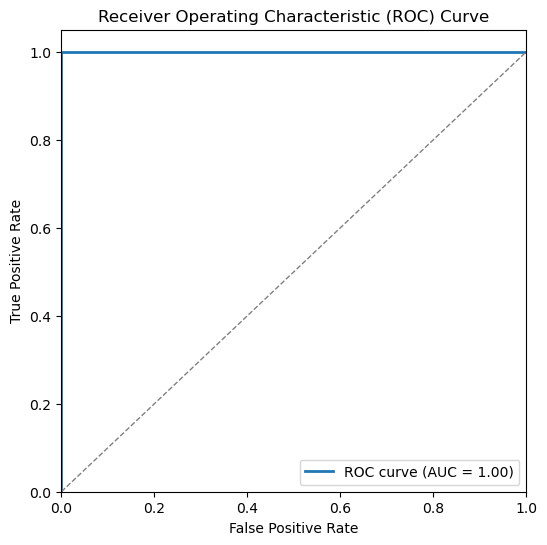

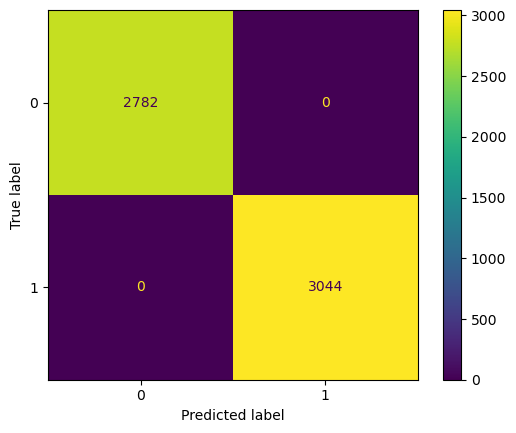

accuracy score: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2782
           1       1.00      1.00      1.00      3044

    accuracy                           1.00      5826
   macro avg       1.00      1.00      1.00      5826
weighted avg       1.00      1.00      1.00      5826



['pretrained_models/Random_Forest.joblib']

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize


rf = RandomForestClassifier(random_state=0)


param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average='macro'),
    "recall": make_scorer(recall_score, average='macro'),
    "f1": make_scorer(f1_score, average='macro')
}

# --- 4. GridSearchCV setup ---
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=cv,
    n_jobs=-1,          
    verbose=2
)

# --- 5. Fit GridSearchCV on your training data ---
grid_search.fit(X_train, y_train)

print("Best hyperparameters found:")
print(grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# --- 6. Evaluate best model on test set ---
best_rf = grid_search.best_estimator_

# Probabilities for ROC
y_proba = best_rf.predict_proba(X_test)[:, 1]

# If binary classification, binarize y_test
y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix
m_r_prediction = best_rf.predict(X_test)
cm = confusion_matrix(y_test, m_r_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot()
plt.show()
print(f"accuracy score: {accuracy_score(y_test, m_r_prediction) * 100:.2f}%")
print(classification_report(y_test, m_r_prediction))
joblib.dump(best_rf, "pretrained_models/Random_Forest.joblib")



Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Best hyperparameters found:
{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV accuracy: 0.9998


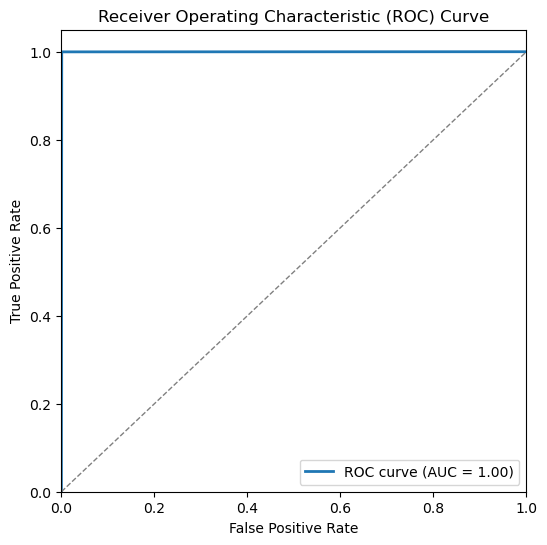

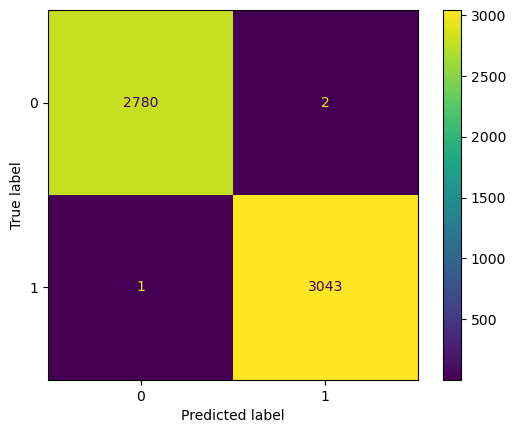

accuracy score: 99.95%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2782
           1       1.00      1.00      1.00      3044

    accuracy                           1.00      5826
   macro avg       1.00      1.00      1.00      5826
weighted avg       1.00      1.00      1.00      5826



['pretrained_models/Decision_Tree.joblib']

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize


param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring='accuracy',  
    cv=cv,
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train, y_train)

print("Best hyperparameters found:")
print(grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

best_dt = grid_search.best_estimator_

if len(best_dt.classes_) == 2:
    y_proba = best_dt.predict_proba(X_test)[:, 1]
    y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()
    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

m_r_prediction = best_dt.predict(X_test)
cm = confusion_matrix(y_test, m_r_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dt.classes_)
disp.plot()
plt.show()

print(f"accuracy score: {accuracy_score(y_test, m_r_prediction) * 100:.2f}%")
print(classification_report(y_test, m_r_prediction))
joblib.dump(best_dt, "pretrained_models/Decision_Tree.joblib")


Fitting 5 folds for each of 2640 candidates, totalling 13200 fits
Best hyperparameters found:
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best CV accuracy: 1.0000


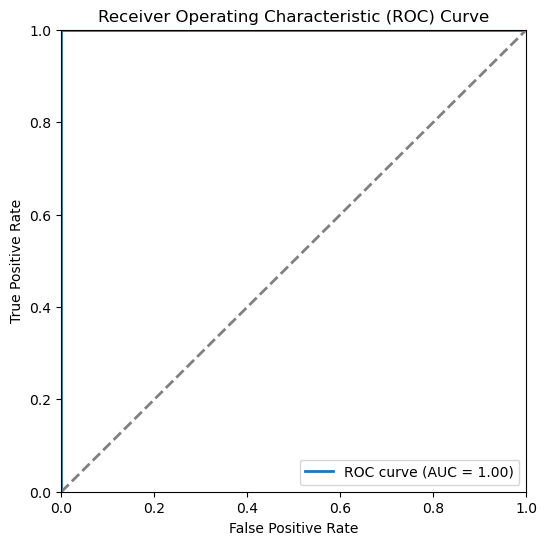

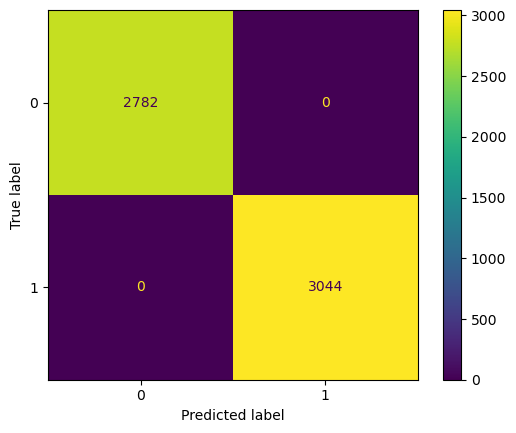

accuracy score:100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2782
           1       1.00      1.00      1.00      3044

    accuracy                           1.00      5826
   macro avg       1.00      1.00      1.00      5826
weighted avg       1.00      1.00      1.00      5826



['pretrained_models/KNN.joblib']

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 19, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'euclidean'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]  
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',  
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters found:")
print(grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

best_knn = grid_search.best_estimator_
if len(best_knn.classes_) == 2:
    y_test_proba = best_knn.predict_proba(X_test)[:, 1]
    y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()
    fpr, tpr, _ = roc_curve(y_test_bin, y_test_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], color='grey', lw=2, linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

m_r_prediction = best_knn.predict(X_test)
cm = confusion_matrix(y_test, m_r_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot()
plt.show()

print(f"accuracy score:{accuracy_score(y_test, m_r_prediction) * 100:.2f}%")
print(classification_report(y_test, m_r_prediction))
joblib.dump(best_knn, "pretrained_models/KNN.joblib")
